Librerias a utilizar

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

import torch
import torchvision
import torchsummary
import torchmetrics
from torch.utils.tensorboard import SummaryWriter

Atributos - definion de clases y size de las imagenes

In [2]:
CANTIDAD_CLASES = 4
ANCHO_IMAGENES = 256
ALTO_IMAGENES = 256

Carga de datos con ImageDataGenerator

In [3]:
from torchvision.models.vgg import VGG19_Weights

weights = VGG19_Weights.IMAGENET1K_V1
transforms = weights.transforms()

Data aumentation

In [4]:
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomResizedCrop(size=(ANCHO_IMAGENES, ALTO_IMAGENES), scale=(0.5, 1.0)),
                        torchvision.transforms.ColorJitter(saturation=0.1, hue=0.1),
                        torchvision.transforms.ToTensor()
                      ])

data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                    torchvision.transforms.ToTensor()
                  ])

#train_set = torchvision.datasets.ImageFolder(root='./train', transform=aug_data_transforms)
#valid_set = torchvision.datasets.ImageFolder(root='./validation', transform=data_transforms)
train_set = torchvision.datasets.ImageFolder(root='Dataset_Splitted_/train', transform=aug_data_transforms)
valid_set = torchvision.datasets.ImageFolder(root='Dataset_Splitted_/val', transform=data_transforms)
test_set = torchvision.datasets.ImageFolder(root='Dataset_Splitted_/test', transform=data_transforms)



train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)


Carga de modelo base

In [5]:
vgg19_model = torchvision.models.vgg19(weights=weights)

vgg19_model.to("cuda")

torchsummary.summary(vgg19_model, input_size=(3, 224, 224))
vgg19_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_

Congelando capas red base

In [6]:
for param in vgg19_model.parameters():
    param.requires_grad = False

Modificand capa base de acuerdo al numero de clases del problema para este caso 4

In [7]:
last_layer_in_features = vgg19_model.classifier[-1].in_features
vgg19_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)   ### 4 clases 

In [8]:
#verificando el cambio
vgg19_model.modules

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_

In [9]:
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None):

    train_loader = data["train"]
    valid_loader = data["valid"]

    train_writer = tb_writer["train"]
    valid_writer = tb_writer["valid"]

    if tb_writer:
        train_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))
        valid_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))

    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += metric(output, valid_target).item()

        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            valid_writer.add_scalar("loss", epoch_valid_loss, epoch)
            train_writer.add_scalar("accuracy", epoch_train_accuracy, epoch)
            valid_writer.add_scalar("accuracy", epoch_valid_accuracy, epoch)
            train_writer.flush()
            valid_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

In [10]:
#verificar si esta activa la gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

entrenamiento

Epoch: 1/100 - Train loss 0.977354 - Train Accuracy 0.661548 - Valid Loss 0.734194 - Valid Accuracy 0.727679
Epoch: 2/100 - Train loss 0.670345 - Train Accuracy 0.785179 - Valid Loss 0.548797 - Valid Accuracy 0.845982
Epoch: 3/100 - Train loss 0.573412 - Train Accuracy 0.811786 - Valid Loss 0.458952 - Valid Accuracy 0.868304
Epoch: 4/100 - Train loss 0.515432 - Train Accuracy 0.829226 - Valid Loss 0.412335 - Valid Accuracy 0.879464
Epoch: 5/100 - Train loss 0.471395 - Train Accuracy 0.844286 - Valid Loss 0.565189 - Valid Accuracy 0.816964
Epoch: 6/100 - Train loss 0.441717 - Train Accuracy 0.850417 - Valid Loss 0.367741 - Valid Accuracy 0.888393
Epoch: 7/100 - Train loss 0.417233 - Train Accuracy 0.861845 - Valid Loss 0.440647 - Valid Accuracy 0.823661
Epoch: 8/100 - Train loss 0.409646 - Train Accuracy 0.857202 - Valid Loss 0.339989 - Valid Accuracy 0.890625
Epoch: 9/100 - Train loss 0.397628 - Train Accuracy 0.858571 - Valid Loss 0.329117 - Valid Accuracy 0.897321
Epoch: 10/100 - Tra

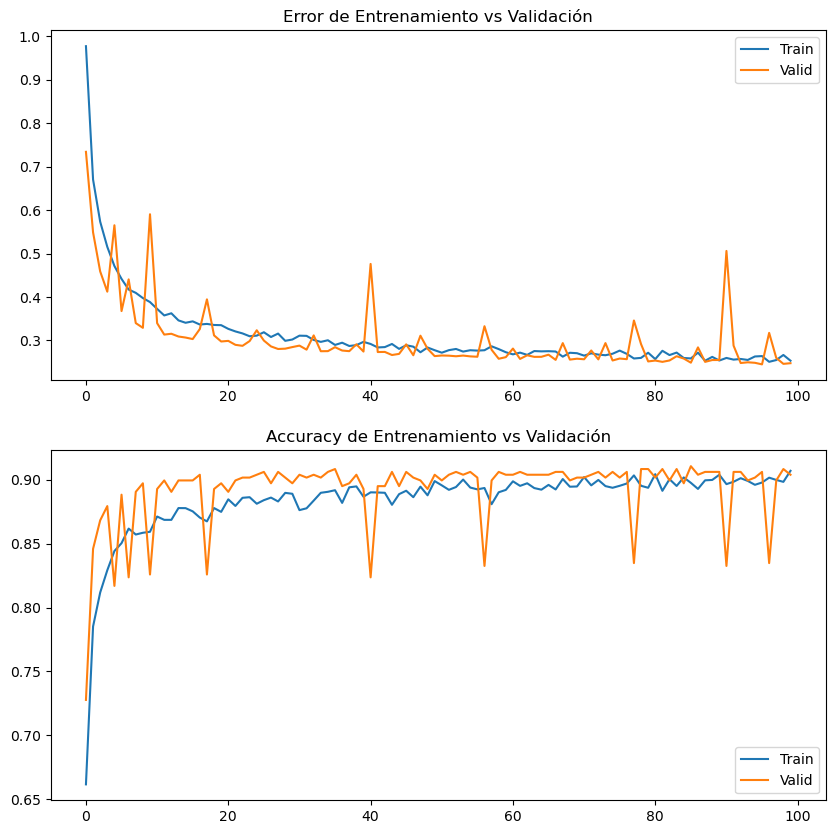

In [11]:
Epochs=100
learning_rate= 0.0001
optimizer = torch.optim.Adam(vgg19_model.parameters(), lr=learning_rate)
loss = torch.nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
data = {"train": train_loader, "valid": valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}
writer = {"train": SummaryWriter(log_dir="transfer_learning_vgg/train"),
          "valid": SummaryWriter(log_dir="transfer_learning_vgg/valid")}

history = train(vgg19_model.to("cpu"),
                optimizer,
                loss,
                metric,
                data,
                Epochs,
                writer)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

In [12]:
#funcion para calcular accuracy
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)
        return float(num_correct)/num_total

In [13]:

ac_train=accuracy(vgg19_model, train_loader)
ac_val=accuracy(vgg19_model, valid_loader) 
ac_test=accuracy(vgg19_model, test_loader)

print(f"Accuracy Training {ac_train}")
print(f"Accuracy Validation {ac_val}")
print(f"Accuracy Testing {ac_test}")

Accuracy Training 0.9253285543608124
Accuracy Validation 0.8968824940047961
Accuracy Testing 0.8983451536643026


In [14]:
PATH = 'Modelos_entrenados/vgg19v1_hiper.pt'
#Modelos_entrenados
torch.save(vgg19_model.state_dict(), PATH)